# Web attack detection using CICIDS2017 dataset

Training data: "Intrusion Detection Evaluation Dataset" (CICIDS2017). Description page: https://www.unb.ca/cic/datasets/ids-2017.html

The data set is public. Download link: http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/

CICIDS2017 combines 8 files recorded on different days of observation (PCAP + CSV). Used archive: http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/GeneratedLabelledFlows.zip

In the downloaded archive GeneratedLabelledFlows.zip the file "Thursday" Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv is selected.

Sources:

* [Sharafaldin2018] Iman Sharafaldin, Arash Habibi Lashkari and Ali A. Ghorbani. Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization. 2018
* [Kostas2018] Kahraman Kostas. Anomaly Detection in Networks Using Machine Learning. 2018 (error was found in assessing the importance of features)
* https://github.com/bozbil/Anomaly-Detection-in-Networks-Using-Machine-Learning (error was found in assessing the importance of features)

## 1. Data preprocessing

Source: https://github.com/bozbil/Anomaly-Detection-in-Networks-Using-Machine-Learning/blob/master/01_preprocessing.ipynb [Kostas2018].

In [32]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

Download the dataset from Github to Google Colab and unzip it.

In [33]:
!wget https://raw.githubusercontent.com/infosecdemos/ml-2020/master/ml-ids/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.zip -O dataset.zip
!unzip -u dataset.zip

--2020-09-28 13:49:02--  https://raw.githubusercontent.com/infosecdemos/ml-2020/master/ml-ids/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15190336 (14M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  14.49M  24.4MB/s    in 0.6s    

2020-09-28 13:49:03 (24.4 MB/s) - ‘dataset.zip’ saved [15190336/15190336]

Archive:  dataset.zip


We use "engine=python" to avoid the "UnicodeDecodeError: 'utf-8' codec can't decode byte 0x96 in position 11: invalid start byte" encoding error.

In [34]:
df = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', engine='python')

Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv file contains 458968 records, 85 columns.

In [35]:
df.shape

(458968, 85)

The columns "Fwd Header Length" and "Fwd Header Length.1" are identical, the second one is removed, 84 columns remain.

In [36]:
df.columns = df.columns.str.strip()
df = df.drop(columns=['Fwd Header Length.1'])
df.shape

(458968, 84)

When assessing the distribution of labels, it turns out that out of 458968 records there are many blank records ("BENIGN" - benign background traffic).

In [37]:
df['Label'].unique()

array(['BENIGN', 'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', nan], dtype=object)

In [38]:
df['Label'].value_counts()

BENIGN                        168186
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Web Attack � Sql Injection        21
Name: Label, dtype: int64

Delete blank records.

In [39]:
df = df.drop(df[pd.isnull(df['Flow ID'])].index)
df.shape

(170366, 84)

Replace the NaN values with zeros.

In [40]:
df.fillna(0, inplace=True)

The "Flow Bytes/s" and "Flow Packets/s" columns have non-numerical values, replace them.

In [41]:
df.replace('Infinity', -1, inplace=True)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

Convert string characters to numbers, use LabelEncoder, not OneHotEncoder.

In [42]:
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']

In [43]:
le = preprocessing.LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))

### Undersampling against unbalance

Dataset is unbalanced: total records = 170366, "BENIGN" records = 168186, records with attacks much less: 1507 + 652 + 21 = 2180.

In [44]:
benign_total = len(df[df['Label'] == "BENIGN"])
benign_total

168186

In [45]:
attack_total = len(df[df['Label'] != "BENIGN"])
attack_total

2180

In [46]:
df.to_csv("web_attacks_unbalanced.csv", index=False)
df['Label'].value_counts()

BENIGN                        168186
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Web Attack � Sql Injection        21
Name: Label, dtype: int64

We use **undersampling** to correct class imbalances: we remove most of the "BENIGN" records.

Form a balanced dataset web_attacks_balanced.csv in proportion: 30% attack (2180 records), 70% benign data (2180 / 30 * 70 ~ = 5087 records).

Algorithm to form a balanced df_balanced dataset:

* All the records with the attacks are copied to the new dataset.
* There are two conditions for copying "BENIGN" records to the new dataset:
 
     1. The next record is copyied with the benign_inc_probability.
     2. The total number of "BENIGN" records must not exceed the limit of 5087 records.

Сalculate the probability of copying a "BENIGN" record. The enlargement multiplier is used to get exactly 70% benign data (5087 records).

In [47]:
enlargement = 1.1
benign_included_max = attack_total / 30 * 70
benign_inc_probability = (benign_included_max / benign_total) * enlargement
print(benign_included_max, benign_inc_probability)

5086.666666666667 0.03326872232726466


Copy records from df to df_balanced, save dataset **web_attacks_balanced.csv**.

In [17]:
import random
indexes = []
benign_included_count = 0
for index, row in df.iterrows():
    if (row['Label'] != "BENIGN"):
        indexes.append(index)
    else:
        # Copying with benign_inc_probability
        if random.random() > benign_inc_probability: continue
        # Have we achieved 70% (5087 records)?
        if benign_included_count > benign_included_max: continue
        benign_included_count += 1
        indexes.append(index)
df_balanced = df.loc[indexes]

In [18]:
df_balanced['Label'].value_counts()

BENIGN                        5087
Web Attack � Brute Force      1507
Web Attack � XSS               652
Web Attack � Sql Injection      21
Name: Label, dtype: int64

If necessary, we can keep a single class of attack for experiments.

In [19]:
# df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Brute Force"]
# df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Sql Injection"]
# df_balanced['Label'].value_counts()

In [20]:
df_balanced.to_csv("web_attacks_balanced.csv", index=False)

## Preparing data for training

7 features (Flow ID, Source IP, Source Port, Destination IP, Destination Port, Protocol, Timestamp) are excluded from the dataset. The hypothesis is that the "shape" of the data being transmitted is more important than these attributes. In addition, ports and addresses can be substituted by an attacker, so it is better that the ML algorithm does not take these features into account in training [Kostas2018].

In [21]:
df = pd.read_csv('web_attacks_balanced.csv')
excluded = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']
df = df.drop(columns=excluded)

Below at the stage of importance estimation the "Init_Win_bytes_backward" feature has the maximum value. After viewing the source dataset, it seems that an inaccuracy was made in forming the dataset. 

It turns out that it is possible to make a fairly accurate classification by one feature.

Description of features: http://www.netflowmeter.ca/netflowmeter.html

     Init_Win_bytes_backward - The total number of bytes sent in initial window in the backward direction
     Init_Win_bytes_forward - The total number of bytes sent in initial window in the forward direction

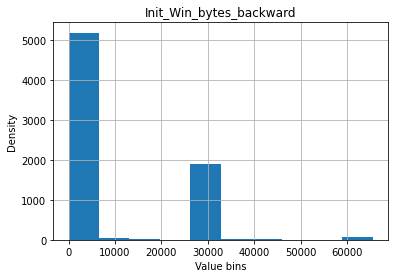

In [22]:
if 'Init_Win_bytes_backward' in df.columns:
    df['Init_Win_bytes_backward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_backward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_backward.png', dpi=300)

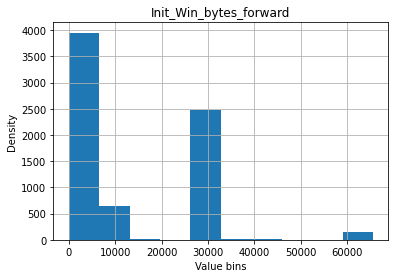

In [23]:
if 'Init_Win_bytes_forward' in df.columns:
    df['Init_Win_bytes_forward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_forward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_forward.png', dpi=300)

In [24]:
excluded2 = ['Init_Win_bytes_backward', 'Init_Win_bytes_forward']
df = df.drop(columns=excluded2)

The Label column is encoded as follows: "BENIGN" = 0, attack = 1.

In [25]:
df = pd.read_csv('web_attacks_balanced.csv')
excluded = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']
df = df.drop(columns=excluded)
excluded2 = ['Init_Win_bytes_backward', 'Init_Win_bytes_forward']
df = df.drop(columns=excluded2)

df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y = df['Label'].values
X = df.drop(columns=['Label'])
df1 = X.iloc[:, 0:20]
X = df1.copy()
print(X.shape, y.shape)
X.describe()

(7267, 20) (7267,)


,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total
count,7.267000e+03,7267.000000,7267.000000,7267.000000,7.267000e+03,7267.000000,7267.00000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7.263000e+03,7.263000e+03,7.267000e+03,7.267000e+03,7.267000e+03,7.267000e+03,7.267000e+03
mean,1.054318e+07,10.045961,9.487684,857.723820,1.123396e+04,125.516857,15.79634,36.465261,37.443198,304.542865,37.536673,121.958616,94.884677,1.594895e+06,4.305725e+04,1.117948e+06,1.946198e+06,4.488933e+06,7.867260e+04,1.028333e+07
std,2.684171e+07,224.507363,340.325074,5422.876983,6.088340e+05,350.243184,28.23700,67.918328,112.364753,725.501817,62.331558,246.429169,247.620784,3.290097e+07,2.042599e+05,3.285610e+06,5.014647e+06,1.142724e+07,1.792886e+06,2.673843e+07
min,0.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,3.119568e-02,0.000000e+00,0.000000e+00,0.000000e+00,-1.100000e+01,0.000000e+00
25%,2.440000e+02,2.000000,1.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,7.475332e-01,1.136667e+02,0.000000e+00,2.125000e+02,3.000000e+00,3.000000e+00
50%,1.031110e+05,3.000000,1.000000,46.000000,4.800000e+01,31.000000,0.00000,27.125000,0.000000,46.000000,0.000000,42.000000,0.000000,6.327195e+02,3.299459e+01,5.035400e+04,2.734908e+04,8.823100e+04,5.200000e+01,2.521900e+04
75%,5.568744e+06,3.000000,2.000000,96.000000,2.360000e+02,50.000000,35.00000,47.000000,0.000000,136.000000,67.000000,121.000000,0.000000,1.604582e+04,1.360236e+04,1.777134e+06,3.093322e+06,5.458696e+06,1.320000e+02,5.511692e+06
max,1.199984e+08,19004.000000,28926.000000,157816.000000,5.180000e+07,9670.000000,1472.00000,1472.000000,1689.950705,7926.000000,1430.000000,2048.896703,2479.122089,2.070000e+09,3.000000e+06,6.410000e+07,6.890000e+07,1.190000e+08,6.410000e+07,1.200000e+08


## 2. Feature importance

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 3547, 1: 1539}

### Visualization of the decision tree, importance evaluation using a single tree (DecisionTreeClassifier)
 
In the beginning we use one tree - for the convenience of visualization of the classifier. High cross-validation scores even with 5 leaves look suspiciously good, we should look at the data carefully. Parameters for change - test_size in the cell above (train_test_split), max_leaf_nodes in the cell below.
 
By changing the **random_state** parameter, we will get different trees and different features with the highest importance. But the forest will already average individual trees below.

In [27]:
from sklearn.model_selection import cross_val_score
# from sklearn.tree.export import export_text
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
decision_tree = decision_tree.fit(X_train[1:100], y_train[1:100])
cross_val_score(decision_tree, X_train, y_train, cv=10)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [28]:
# https://pair-code.github.io/facets/
!pip install facets-overview

In [29]:
!wget https://raw.githubusercontent.com/infosecdemos/ml-2020/master/ml-ids/datasets/web_attacks_balanced.zip -O web_attacks_balanced.zip
!unzip -u web_attacks_balanced.zip
df = pd.read_csv('web_attacks_balanced.csv')

--2020-09-28 13:48:38--  https://raw.githubusercontent.com/infosecdemos/ml-2020/master/ml-ids/datasets/web_attacks_balanced.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 768997 (751K) [application/zip]
Saving to: ‘web_attacks_balanced.zip’

web_attacks_balance 100%[===================>] 750.97K  --.-KB/s    in 0.1s    

2020-09-28 13:48:38 (6.73 MB/s) - ‘web_attacks_balanced.zip’ saved [768997/768997]

Archive:  web_attacks_balanced.zip


In [30]:
# Create the feature stats for the datasets and stringify it.
import base64
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator

gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train + test', 'table': df}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

In [31]:
# Display the facets overview visualization for this data
from IPython.core.display import display, HTML

HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))